# Dataset Class

In [59]:
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import numpy as np



# Dataset Information:
# All images of 512 x 512
# X : Tomography - image reconstructed - already normalized (0-1)
# y : Mask - unique values (0: background - 1: kidney - 2: tumor - 3: cyst)

# LABEL_AGGREGATION_ORDER = (1, 3, 2) The order matters!
# This means that we first place the kidney, then the cyst and finally the tumor.
# If parts of a later label (example tumor) overlap with a prior label (kidney or cyst) the prior label is overwritten.
#
# KITS_LABEL_NAMES = {
#     1: "kidney",
#     2: "tumor",
#     3: "cyst"
# }

class TomographyDataset(Dataset):  
    
    def __init__(self, data_dir = './data/', dataset_csv = './data/dataset.csv', split_set ='train', transform = None):
        super(Dataset, self).__init__()
        self.data_dir = data_dir
        self.dataset_df = pd.read_csv(dataset_csv)
        self.split_set = split_set
        self.transform = transform 

        if self.split_set == 'train':
            self.dataset_df = self.dataset_df[self.dataset_df['split_set'] == 'train']

        elif self.split_set == 'validation':
            self.dataset_df = self.dataset_df[self.dataset_df['split_set'] == 'validation']
        
        elif self.split_set == 'test':
            self.dataset_df = self.dataset_df[self.dataset_df['split_set'] == 'test']
        
        self.dataset_df.reset_index(inplace=True, drop=True)

    
    def __getitem__(self, index):
        X_path = self.dataset_df['reconstruction_file'][index]
        y_path = self.dataset_df['mask_file'][index]

        X_img = np.load(self.data_dir + X_path)

        # condition to create an image if it does not exist
        try:
            y_img = np.load(self.data_dir + y_path)
        except:
            y_img = np.zeros(shape = (512,512))

        if self.transform is not None:
            augmentations = self.transform(image = X_img, mask = y_img)
            X_img_a = augmentations['image']
            y_img_a = augmentations['mask'] #check if labels are still ok
            
            #print(f'X_img shape: {X_img.shape}')  # 1,H,W
            #print(f'y_img shape: {y_img.shape}')  # H,W
        else:
            X_img_a = X_img 
            y_img_a = y_img

        y_img4 = self.one_hot_encoding(y_img_a)
        item = X_img_a, y_img4
        
        return item, X_img, y_img, y_img_a
    
    def __len__(self): 
        return self.dataset_df.shape[0] 
    
    @staticmethod
    def one_hot_encoding(mask_img):
        shape = mask_img.shape # H,W
        ohe = np.zeros(shape = (4,shape[0],shape[1]))
        for i in range(shape[0]):
            for j in range(shape[1]):
                label = mask_img[i,j]
                if label == 0: # background
                    ohe[:,i,j] = [1,0,0,0] # background, kidney, tumor, cyst
                elif label == 1: # kidney
                    ohe[:,i,j] = [0,1,0,0]
                elif label == 3: # 3 = cyst
                    ohe[:,i,j] = [0,1,0,1]
                elif label == 2: # tumor
                    ohe[:,i,j] = [0,1,1,1]

        return ohe # 4 channels 


## All classes present

(512, 512) (4, 512, 512)


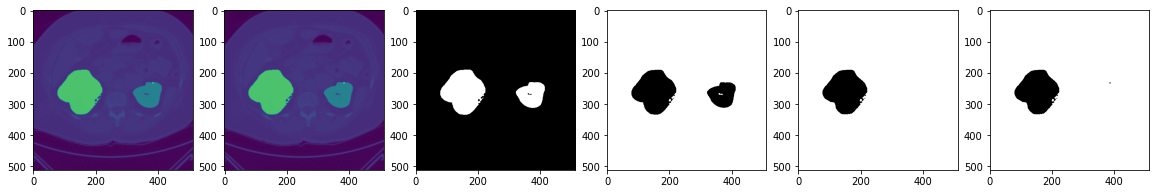

In [65]:
td = TomographyDataset()
# img idx = 104 show all classes
(X, y), X_img, y_img, y_img_a = td.__getitem__(104)
print(X.shape, y.shape)

fig, ax = plt.subplots(ncols=6, figsize=(20,10))
ax=ax.reshape(-1)
ax[0].imshow(X_img +y_img) # original
ax[1].imshow(X + y_img_a) # transformed
ax[2].imshow(y[0], cmap='Greys', vmin = 0, vmax = 1) # background
ax[3].imshow(y[1], cmap='Greys', vmin = 0, vmax = 1) # kidney
ax[4].imshow(y[2], cmap='Greys', vmin = 0, vmax = 1) # tumor
ax[5].imshow(y[3], cmap='Greys', vmin = 0, vmax = 1) # cyst


# Data Augmentation - ROTATION

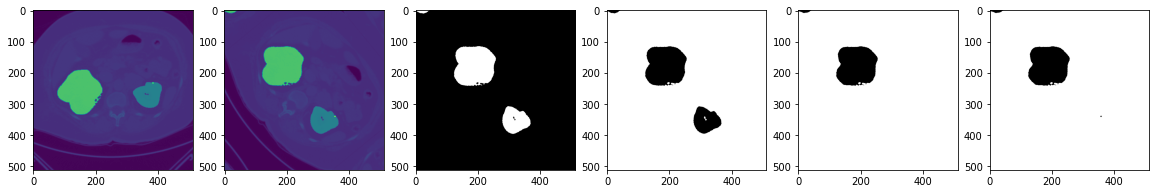

In [69]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

height = 256
width = 256

train_transform = A.Compose(
        [
            A.Rotate(limit=90, p=1.0), # slight rotation
        ],
    )

td = TomographyDataset(transform=train_transform)

# img idx = 104 show all classes
(X, y), X_img, y_img, y_img_a = td.__getitem__(104)

fig, ax = plt.subplots(ncols=6, figsize=(20,10))
ax=ax.reshape(-1)
ax[0].imshow(X_img +y_img) # original
ax[1].imshow(X + y_img_a) # transformed
ax[2].imshow(y[0], cmap='Greys', vmin = 0, vmax = 1) # background
ax[3].imshow(y[1], cmap='Greys', vmin = 0, vmax = 1) # kidney
ax[4].imshow(y[2], cmap='Greys', vmin = 0, vmax = 1) # tumor
ax[5].imshow(y[3], cmap='Greys', vmin = 0, vmax = 1) # cyst

## Data Augmentation - HorizontalFlip

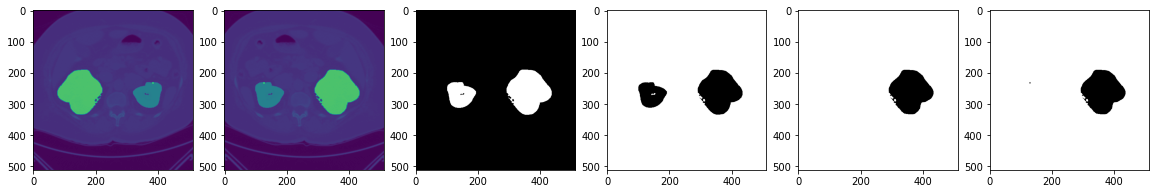

In [70]:
height = 256
width = 256

train_transform = A.Compose(
        [
            A.HorizontalFlip(p=1.0),
        ],
    )

td = TomographyDataset(transform=train_transform)

# img idx = 104 show all classes
(X, y), X_img, y_img, y_img_a = td.__getitem__(104)

fig, ax = plt.subplots(ncols=6, figsize=(20,10))
ax=ax.reshape(-1)
ax[0].imshow(X_img +y_img) # original
ax[1].imshow(X + y_img_a) # transformed
ax[2].imshow(y[0], cmap='Greys', vmin = 0, vmax = 1) # background
ax[3].imshow(y[1], cmap='Greys', vmin = 0, vmax = 1) # kidney
ax[4].imshow(y[2], cmap='Greys', vmin = 0, vmax = 1) # tumor
ax[5].imshow(y[3], cmap='Greys', vmin = 0, vmax = 1) # cyst

## Data Augmentation - VerticalFlip

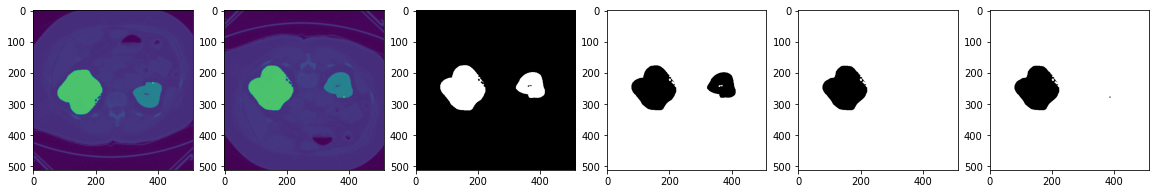

In [72]:
height = 256
width = 256

train_transform = A.Compose(
        [
            A.VerticalFlip(p=1.0),
        ],
    )

td = TomographyDataset(transform=train_transform)

# img idx = 104 show all classes
(X, y), X_img, y_img, y_img_a = td.__getitem__(104)

fig, ax = plt.subplots(ncols=6, figsize=(20,10))
ax=ax.reshape(-1)
ax[0].imshow(X_img +y_img) # original
ax[1].imshow(X + y_img_a) # transformed
ax[2].imshow(y[0], cmap='Greys', vmin = 0, vmax = 1) # background
ax[3].imshow(y[1], cmap='Greys', vmin = 0, vmax = 1) # kidney
ax[4].imshow(y[2], cmap='Greys', vmin = 0, vmax = 1) # tumor
ax[5].imshow(y[3], cmap='Greys', vmin = 0, vmax = 1) # cyst

In [40]:
# Find train index with all classes in one image
i = 0
y = np.zeros(shape = (512,512))

print(np.unique(y))

while (np.sum(np.unique(y)) != 6):
    print(np.unique(y))
    (X, y4), y = td.__getitem__(i) # show reconstruction, mask, superposed (reco + mask)
    i += 1

print(i-1)

[0.]
[0.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1. 3.]
[0. 1. 3.]
[0. 1. 3.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1. 3.]
[0. 1. 3.]
[0. 1. 3.]
[0. 1. 3.]
[0. 1. 3.]
[0. 1. 3.]
[0. 1. 3.]
[0. 1.]
[0. 1. 2.]
[0. 1. 2.]
[0. 1. 2.]
[0. 1. 2.]
[0. 1. 2.]
[0. 1. 2.]
[0. 1. 2.]
[0. 1. 2.]
[0. 1. 2.]
[0. 1. 2.]
[0. 1. 2.]
[0. 1. 2.]
[0. 1. 2.]
[0. 1. 2.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 1.]
[0. 2.]
[0. 1. 2.]
[0. 1. 2.]
[0. 1. 2.]
[0. 1. 2.]
[0. 1. 2.]
[0. 1. 2.]
104


In [73]:
my_train = TomographyDataset(split_set ='train')
my_val = TomographyDataset(split_set ='validation')
my_test = TomographyDataset(split_set ='test')

print(my_train.__len__()) 
print(my_val.__len__()) 
print(my_test.__len__()) 

my_val.dataset_df.head()

1316
184
1517


,Unnamed: 0,patient_idx,number_of_slice,niigz_file_location,split_set,mu_water,photons_per_pixel,source_to_axis,det_to_axis,det_spacing,...,object_size,slice_index,is_mask,slice_min_value,slice_max_value,image_file,sinogram_normalization_factor,sinogram_file,reconstruction_file,mask_file
0,51720,61,29,case_00061/imaging.nii.gz,validation,0.02,10000.0,1000,500,0.9,...,256,0,False,-2048.0,919.0,normalized/case_00061_0.png,5.12,sinogram/case_00061_0.npy,reconstruction/case_00061_0.npy,mask/case_00061_0.npy
1,51721,61,29,case_00061/imaging.nii.gz,validation,0.02,10000.0,1000,500,0.9,...,256,1,False,-2048.0,998.0,normalized/case_00061_1.png,5.12,sinogram/case_00061_1.npy,reconstruction/case_00061_1.npy,mask/case_00061_1.npy
2,51722,61,29,case_00061/imaging.nii.gz,validation,0.02,10000.0,1000,500,0.9,...,256,2,True,-2048.0,1023.0,normalized/case_00061_2.png,5.12,sinogram/case_00061_2.npy,reconstruction/case_00061_2.npy,mask/case_00061_2.npy
3,51723,61,29,case_00061/imaging.nii.gz,validation,0.02,10000.0,1000,500,0.9,...,256,3,True,-2048.0,1033.0,normalized/case_00061_3.png,5.12,sinogram/case_00061_3.npy,reconstruction/case_00061_3.npy,mask/case_00061_3.npy
4,51724,61,29,case_00061/imaging.nii.gz,validation,0.02,10000.0,1000,500,0.9,...,256,4,True,-2048.0,1094.0,normalized/case_00061_4.png,5.12,sinogram/case_00061_4.npy,reconstruction/case_00061_4.npy,mask/case_00061_4.npy


# How Sigmoid Function works on Tensors

In [134]:
import torch.nn as nn
import torch 

m = nn.Sigmoid()
input = torch.randn(size=(1,4,2,2))
output = m(input)

print(f'input {input}')
print(f'output {output}')

input tensor([[[[-2.0380, -0.4217],
          [ 0.6743,  2.3554]],

         [[ 0.0976, -0.0960],
          [-0.3054, -0.2442]],

         [[-2.4085, -1.8864],
          [-0.5039, -0.1638]],

         [[ 0.5578, -0.1139],
          [ 0.5794,  0.4838]]]])
output tensor([[[[0.1153, 0.3961],
          [0.6625, 0.9134]],

         [[0.5244, 0.4760],
          [0.4242, 0.4392]],

         [[0.0825, 0.1317],
          [0.3766, 0.4591]],

         [[0.6360, 0.4716],
          [0.6409, 0.6186]]]])


 ## Jaccard index implementation

In [10]:
import torch
import numpy as np

num_batch = 1
ji_sum = torch.zeros(1,4)
count = 0
th = 0.5

for i in range(num_batch):
    y = torch.empty((1,4,3,3)).random_(2)
    y_pred = y
    y_pred = torch.rand((1,4,3,3))
    y_pred = torch.where(y_pred > th, 1., 0.)
    shape = y.size()
    
    ji =torch.sum((y * y_pred), dim=(2,3))/torch.sum((y + y_pred - y * y_pred), dim=(2,3))
    ji = torch.sum(ji,dim = 0)

    ji_sum = ji_sum + ji
    count += shape[0] # images per batch


ji_sum = ji_sum.cpu().detach().numpy()
ji_sum = ji_sum/count
ji_sum = np.around(ji_sum, 5)

ji_avg_sum = np.mean(ji_sum)

print(f'Jaccard Index for each class: {ji_sum}')
print(f'Average Jaccard Index: {ji_avg_sum}')

Jaccard Index for each class: [[0.5     0.33333 0.14286 0.375  ]]
Average Jaccard Index: 0.33779752254486084


# How Binary Cross Entropy Loss works

In [12]:
import torch
from torch.nn import BCELoss
from torch.nn import Sigmoid

m = Sigmoid()
loss = BCELoss(reduction='mean') # element wise:  -[yn*ln(xn) + (1-yn)*ln(1-xn)] 

input = torch.randn((2,4,3,3), requires_grad=True)
target = torch.empty((2,4,3,3)).random_(2)

x = m(input)
print(x)
print(target)

output = loss(x, target)
print(output)
# output.backward()

tensor([[[[0.1976, 0.5800, 0.4721],
          [0.1778, 0.7560, 0.6167],
          [0.6006, 0.8356, 0.3120]],

         [[0.5111, 0.3411, 0.8018],
          [0.1715, 0.9072, 0.3666],
          [0.5299, 0.3873, 0.2831]],

         [[0.1042, 0.3096, 0.3876],
          [0.6655, 0.3596, 0.6197],
          [0.1512, 0.5240, 0.1904]],

         [[0.4703, 0.6013, 0.3222],
          [0.5499, 0.7357, 0.2288],
          [0.5937, 0.6234, 0.5215]]],


        [[[0.4876, 0.5086, 0.6657],
          [0.3948, 0.4893, 0.3434],
          [0.5379, 0.2705, 0.5468]],

         [[0.3955, 0.5853, 0.5886],
          [0.7673, 0.6585, 0.7087],
          [0.8958, 0.4195, 0.5748]],

         [[0.3060, 0.5540, 0.4806],
          [0.3275, 0.8323, 0.5560],
          [0.2185, 0.3130, 0.2916]],

         [[0.8836, 0.7860, 0.3166],
          [0.5078, 0.3512, 0.6656],
          [0.1850, 0.6704, 0.7438]]]], grad_fn=<SigmoidBackward0>)
tensor([[[[1., 0., 1.],
          [1., 0., 0.],
          [0., 1., 0.]],

         [[0., 

# How Binary Cross Entropy Loss works

In [3]:
import torch
from torch.nn import BCEWithLogitsLoss

loss = BCEWithLogitsLoss(reduction='none') # sigmoid to ix then element wise BCE:  -[yn*ln(xn) + (1-yn)*ln(1-xn)] 

input = torch.randn((2,2), requires_grad=True)
target = torch.empty((2,2)).random_(2)

print(input)
print(target)

output = loss(input, target)
print(output)
# output.backward()

tensor([[0.2370, 1.5673],
        [0.5148, 1.3173]], requires_grad=True)
tensor([[1., 1.],
        [0., 0.]])
tensor([[0.5817, 0.1895],
        [0.9833, 1.5547]], grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
